In [1]:
date = '20181116'
ticker = 'LUV'
start = '9:30:00'
end = '10:00:00'
intv = 10
freq = 'second'
# quote_file_name = 'quote_data'
# trade_file_name = 'trade_data'
t_list = 'NKTR AIG AMD LUV PCH WDC NCLH CELG DWDP SPXC'
d_list = '20181101-20181116'

In [2]:
import pandas as pd
import numpy as np

# Finding optimal execution strategy over a fixed period of times for a target order via the Dynamic programming approach.

$m_t=m_{t-1}+\mu+\lambda s_t+e_t$

$p_t=m_t+\gamma s_t$

If $\mu=0$, $s^\star_t=S/T$

Else, $s^\star_t=S(\frac{1}{T}+\frac{T+1-2t}{4\gamma +2\lambda} \mu)$

In [3]:
def size_optimal(T,S,mu,gamma,lbd):
    if mu==0:
        return np.ones(T)*S/float(T)
    else:
        return S*(1.0/float(T)+(T+1.)*mu/float(4*gamma+2*lbd))-np.arange(1,T+1)*S*mu/float(2*gamma+lbd)

In [4]:
# #Ex
# size_optimal(10,10000,0.01,0.2,0.5)

We need good estimates of the hidden parameters which we will fit using the market quote and price data.

In [5]:
data = pd.read_csv('quote_{}.csv'.format(date, header=0))
df = data[data.SYM_ROOT.values == ticker]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# df

We select out valid data that has nonzero bid price and ask price that is not NAN. The data is merged into 10 second level frames. 
The midpoint $M_t$ is calculated as the average of bid and ask price.

In [7]:
Mt=[]
T=[]
for j in range(len(df['TIME_M'])):
    
    if np.array(df['TIME_M'])[j][:6]+'0' not in T and np.array(df['BID'])[j]>0 and np.array(df['ASK'])[j]<199999.99:       
        T.append(np.array(df['TIME_M'])[j][:6]+'0')  
        Mt.append(0.5*(np.array(df['BID'])[j]+np.array(df['ASK'])[j]))
    else:
        pass

There are 180 periods from 9:30 to 10:00, we fill in the missing times in the original series by a forward filling method.

In [8]:
import time
import datetime
mt=[]
tt=[]
start=datetime.datetime.strptime("09:30:00", "%H:%M:%S")
j=0
for i in range(180):
    tt.append(start)
    if start==datetime.datetime.strptime(T[j],'%H:%M:%S'):
        mt.append(Mt[j])
        j+=1
    else:
        mt.append(Mt[j])
    start+=datetime.timedelta(0,10)

In [9]:
mt=np.array(mt)
len(mt),len(tt)

(180, 180)

In [10]:
data=pd.read_csv('trade_{}.csv'.format(date),header=0)
df_t = data[data.SYM_ROOT.values == ticker]

In [11]:
# df_t

Merge the price data the same way as the quote and ask data, while for the size variable we sum over each 10 second period.

In [12]:
Pt=[]
St=[]
T2=[]
i=-1
for j in range(len(df_t['TIME_M'])):
    if np.array(df_t['TIME_M'])[j][:6]+'0' not in T2:
        i+=1
        T2.append(np.array(df_t['TIME_M'])[j][:6]+'0')
        Pt.append(np.array(df_t['PRICE'])[j])
        St.append(np.array(df_t['SIZE'])[j])
    else:
        St[i]+=np.array(df_t['SIZE'])[j]

In [13]:
len(T2),len(Pt)

(175, 175)

Forward filling to retain a complete series of length 180.

In [14]:
pt=[]
st=[]
ttt=[]
start=datetime.datetime.strptime("09:30:00", "%H:%M:%S")
j=0
for i in range(180):
    ttt.append(start)
    if j<len(T2):
        if start==datetime.datetime.strptime(T2[j],'%H:%M:%S'):
        
            pt.append(Pt[j])
            st.append(St[j])
            j+=1
        else:
            pt.append(pt[-1])
            st.append(0)
    else:
        pt.append(pt[-1])
        st.append(0)
    start+=datetime.timedelta(0,10)

In [15]:
pt=np.array(pt)
st=np.array(st)

check that the two datasets correponds to the same time indices.

In [16]:
common=sorted(set(tt).intersection(set(ttt)))
len(common)

180

Perform the first regression: $M_t-M_{t-1}$ vs. $S_t$

In [17]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
regr = linear_model.LinearRegression()
X=st[1:].reshape(-1,1)
y=np.diff(mt)
regr.fit(X,y)
mu=regr.intercept_
lbd=regr.coef_[0]
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.04584
Date:                Mon, 22 Apr 2019   Prob (F-statistic):              0.831
Time:                        02:37:01   Log-Likelihood:                -597.36
No. Observations:                 179   AIC:                             1199.
Df Residuals:                     177   BIC:                             1205.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0650      0.590     -0.110      0.9

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


No handles with labels found to put in legend.


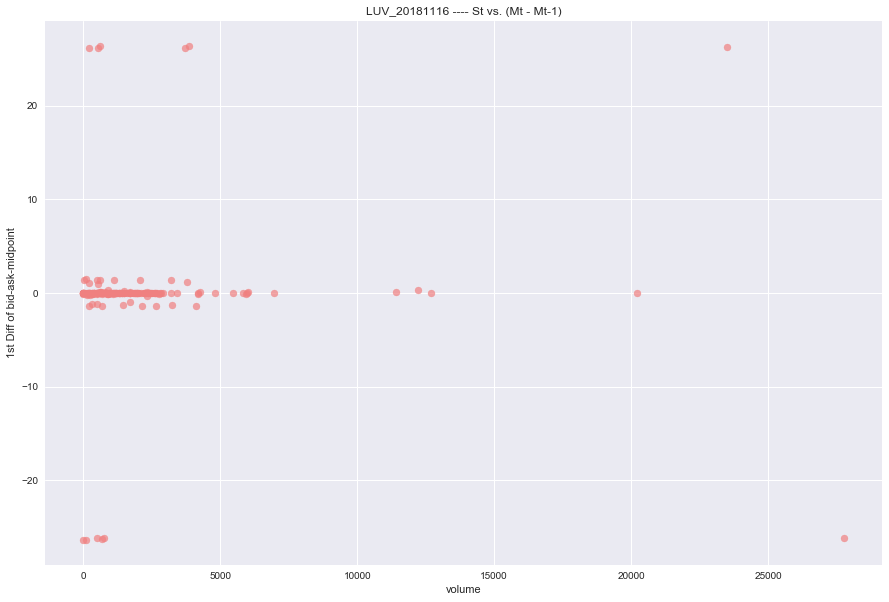

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
plt.figure(figsize = (15,10))
plt.grid(True)
plt.title('{}_{} ---- St vs. (Mt - Mt-1)'.format(ticker, date))
plt.scatter(st[1:].reshape(-1,1), np.diff(mt), color = 'lightcoral', alpha = 0.7)
plt.xlabel('volume')
plt.ylabel('1st Diff of bid-ask-midpoint')
plt.legend()
plt.savefig('{}_{}_1.png'.format(ticker, date))

# Conclusion: $\mu=0$

Second regression on $P_T-M_t$ vs $S_t$

In [19]:
regr2 = linear_model.LinearRegression()
regr2.fit(st.reshape(-1,1),pt-mt)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
gamma=regr2.coef_[0]
gamma

1.8328791015460047e-05

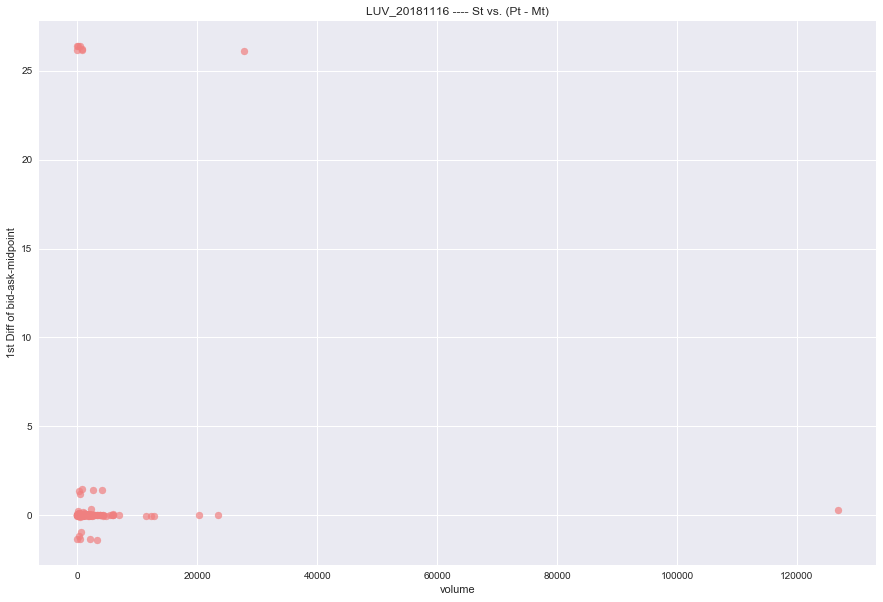

In [21]:
plt.style.use('seaborn')
plt.figure(figsize = (15,10))
plt.grid(True)
plt.title('{}_{} ---- St vs. (Pt - Mt)'.format(ticker, date))
plt.scatter(st.reshape(-1,1), pt-mt,color = 'lightcoral', alpha = 0.7)
plt.xlabel('volume')
plt.ylabel('1st Diff of bid-ask-midpoint')
plt.savefig('{}_{}_2.png'.format(ticker, date))

Results had we assumed these parameters

In [22]:
size_optimal(10,10000,mu,gamma,lbd)

array([-42825622.0749901 , -33308594.94721453, -23791567.81943895,
       -14274540.69166337,  -4757513.5638878 ,   4759513.56388779,
        14276540.69166336,  23793567.81943894,  33310594.94721452,
        42827622.07499009])

Clearly we have found that the market drift parameter is insignificant and had we proceeded with the classical order splitting models we will receive
suggested implementation of executions that are not reasonable given our target. Therefore we conclude that the drift term is zero and use the average splitting strategy
as a baseline for comparison.